In [1]:
## Install packages
import gym
import random
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
env = gym.envs.make("CartPole-v1")

Reward = []
def random_search(env, episodes): 
    for episode in range(episodes):
        rewards = 0
        state = env.reset()
        done = False
        while not done:
            env.render()
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, _ = env.step(action)
            # Update reward
            rewards += reward
            if done:
                break
        # Add to the final reward
        Reward.append(rewards)
    env.close()


# Get random search results
random_search(env, 100)
plt.plot(np.arange(len(Reward)), Reward)
plt.show()

KeyboardInterrupt: 

In [2]:
import copy
import torch
from torch.autograd import Variable
import math
import torchvision.transforms as T

In [3]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [4]:
Reward = []
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        rewards = 0
        
        while not done:
            env.render()
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            rewards += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        Reward.append(rewards)
        
    plt.plot(np.arange(len(Reward)), Reward)
    plt.show()    

In [7]:
env = gym.envs.make("CartPole-v1")
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

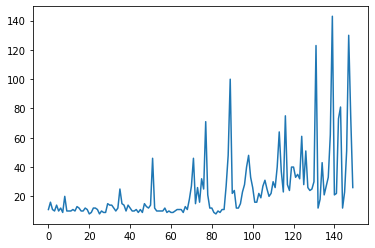

In [24]:
# Get DQN results
simple_dqn = DQN(n_state, n_action, n_hidden, lr)
q_learning(env, simple_dqn, episodes, gamma=.9, epsilon=0.3)

In [8]:
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    #new replay function
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

In [ ]:
# Get replay results
env = gym.envs.make("CartPole-v1")
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')